In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [2]:
# Convolutional VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [3]:
# Loss fonksiyonu
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Model, optimizer
latent_dim = 20
model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch [1/5], Loss: 156.6961
Epoch [2/5], Loss: 114.4064
Epoch [3/5], Loss: 109.6743
Epoch [4/5], Loss: 107.4543
Epoch [5/5], Loss: 106.1729


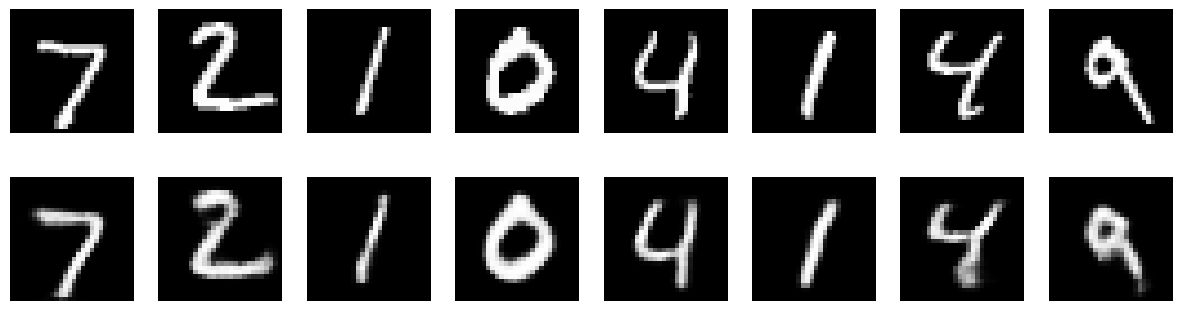

In [4]:
# Eğitim döngüsü
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}")

# Test ve görselleştirme
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        recon_images, _, _ = model(images)
        # İlk 8 örneği görselleştir
        fig, axes = plt.subplots(2, 8, figsize=(15,4))
        for i in range(8):
            axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[0,i].axis('off')
            axes[1,i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
            axes[1,i].axis('off')
        plt.show()
        break

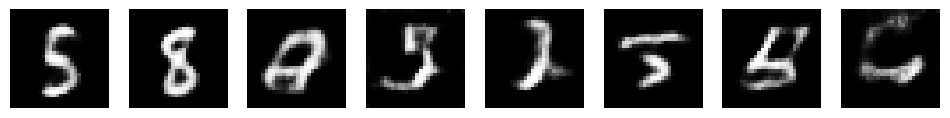

In [5]:
# Modeli eval moduna al
model.eval()
with torch.no_grad():
    # Rastgele latent vektörler oluştur
    num_samples = 8
    z = torch.randn(num_samples, latent_dim).to(device)  # N(0,1) dağılımından
    generated_images = model.decode(z)

    # Görselleştir
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()
